In [54]:
from datetime import datetime, timedelta,date
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from __future__ import division

import warnings
warnings.filterwarnings("ignore")

# import plotly.plotly as py
# import plotly.offline as pyoff
# import plotly.graph_objs as go

import tensorflow.keras

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

# import keras
# from keras.layers import Dense
# from keras.models import Sequential
# from keras.optimizers import Adam 
# from keras.callbacks import EarlyStopping
# from keras.utils import np_utils
# from keras.layers import LSTM
from sklearn.model_selection import KFold, cross_val_score, train_test_split

# #initiate plotly
# pyoff.init_notebook_mode()


In [27]:
# read csv file
import pandas as pd
df_sales = pd.read_csv('C:\\Users\\Prashant\\Downloads\\train.csv')


df_sales.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [28]:
df_sales.shape

(913000, 4)

In [29]:
#represent month in date field as its first day

#convert date field from string to datetime
df_sales['date'] = pd.to_datetime(df_sales['date'])
df_sales['date'] = df_sales['date'].dt.year.astype('str') + '-' + df_sales['date'].dt.month.astype('str') + '-01'
df_sales['date'] = pd.to_datetime(df_sales['date'])
#groupby date and sum the sales
df_sales = df_sales.groupby('date').sales.sum().reset_index()

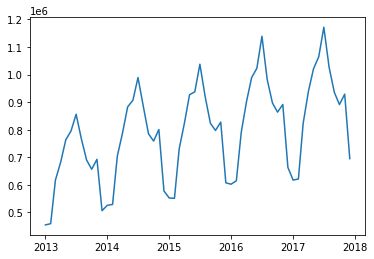

In [30]:
df=df_sales[['date','sales']]
df= df.set_index('date')

plt.plot(df)

In [41]:
df_sales.shape

(60, 2)

In [31]:
#create a new dataframe to model the difference

df_diff = df_sales.copy()
#add previous sales to the next row
df_diff['prev_sales'] = df_diff['sales'].shift(1)
#drop the null values and calculate the difference
df_diff = df_diff.dropna()
df_diff['diff'] = (df_diff['sales'] - df_diff['prev_sales'])
df_diff.head(10)

,date,sales,prev_sales,diff
1,2013-02-01,459417,454904.0,4513.0
2,2013-03-01,617382,459417.0,157965.0
3,2013-04-01,682274,617382.0,64892.0
4,2013-05-01,763242,682274.0,80968.0
5,2013-06-01,795597,763242.0,32355.0
6,2013-07-01,855922,795597.0,60325.0
7,2013-08-01,766761,855922.0,-89161.0
8,2013-09-01,689907,766761.0,-76854.0
9,2013-10-01,656587,689907.0,-33320.0
10,2013-11-01,692643,656587.0,36056.0


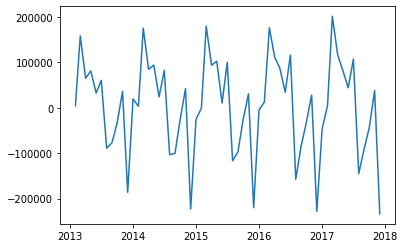

In [34]:
import seaborn as sns

plt.plot( df_diff["date"], df_diff["diff"])

In [35]:
#create dataframe for transformation from time series to supervised

df_supervised = df_diff.drop(['prev_sales'],axis=1)

#adding lags
for inc in range(1,13):
    field_name = 'lag_' + str(inc)
    df_supervised[field_name] = df_supervised['diff'].shift(inc)
#drop null values
df_supervised = df_supervised.dropna().reset_index(drop=True)

In [36]:
df_supervised.head(10)

,date,sales,diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
0,2014-02-01,529117,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0,4513.0
1,2014-03-01,704301,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0
2,2014-04-01,788914,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0
3,2014-05-01,882877,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0
4,2014-06-01,906842,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0
5,2014-07-01,989010,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0
6,2014-08-01,885596,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0
7,2014-09-01,785124,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0
8,2014-10-01,758883,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0
9,2014-11-01,800783,41900.0,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0


In [43]:
# Import statsmodels.formula.api
import statsmodels.formula.api as smf
# Define the regression formula
model = smf.ols(formula='diff ~ lag_1+lag_2+lag_3+lag_4+lag_5+lag_6+lag_7+lag_8+lag_9+lag_10+lag_11+lag_11+lag_12', data=df_supervised)
# Fit the regression
model_fit = model.fit()
# Extract the adjusted r-squared
regression_adj_rsq = model_fit.rsquared_adj
print(regression_adj_rsq)

0.9795722233296558


In [44]:
#import MinMaxScaler and create a new dataframe for LSTM model

from sklearn.preprocessing import MinMaxScaler

df_model = df_supervised.drop(['sales','date'],axis=1)

#split train and test set
train_set, test_set = df_model[0:-6].values, df_model[-6:].values

In [157]:
train_set.shape

(41, 13)

In [47]:
test_set.shape

(6, 13)

In [48]:
#apply Min Max Scaler

scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(train_set)

# reshape training set
train_set = train_set.reshape(train_set.shape[0], train_set.shape[1])
train_set_scaled = scaler.transform(train_set)

# reshape test set
test_set = test_set.reshape(test_set.shape[0], test_set.shape[1])
test_set_scaled = scaler.transform(test_set)

In [49]:
X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1]
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [51]:
X_train.shape, y_train.shape

((41, 1, 12), (41, 1))

In [155]:
#y_train

In [52]:
X_test.shape, y_test.shape

((6, 1, 12), (6, 1))

In [57]:
model = Sequential()
model.add(LSTM(4, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=1, shuffle=False)

Epoch 1/100
41/41 [==============================] - 2s 2ms/step - loss: 0.1994
Epoch 2/100
41/41 [==============================] - 0s 2ms/step - loss: 0.1737
Epoch 3/100
41/41 [==============================] - 0s 2ms/step - loss: 0.1547
Epoch 4/100
41/41 [==============================] - ETA: 0s - loss: 0.131 - 0s 2ms/step - loss: 0.1390
Epoch 5/100
41/41 [==============================] - 0s 2ms/step - loss: 0.1257
Epoch 6/100
41/41 [==============================] - 0s 2ms/step - loss: 0.1145A: 0s - loss: 0.107
Epoch 7/100
41/41 [==============================] - 0s 2ms/step - loss: 0.1049
Epoch 8/100
41/41 [==============================] - 0s 2ms/step - loss: 0.0965
Epoch 9/100
41/41 [==============================] - 0s 2ms/step - loss: 0.0890
Epoch 10/100
41/41 [==============================] - 0s 2ms/step - loss: 0.0823
Epoch 11/100
41/41 [==============================] - 0s 2ms/step - loss: 0.0760
Epoch 12/100
41/41 [==============================] - 0s 2ms/step - loss: 0

In [58]:
y_pred = model.predict(X_test,batch_size=1)
y_pred

array([[ 0.67996544],
       [-0.5996006 ],
       [-0.389538  ],
       [-0.05650208],
       [ 0.13151322],
       [-1.031049  ]], dtype=float32)

In [77]:
#reshape y_pred

y_pred = y_pred.reshape(y_pred.shape[0], 1, y_pred.shape[1])

#rebuild test set for inverse transform

pred_test_set = []
for index in range(0,len(y_pred)):
    print(np.concatenate([y_pred[index],X_test[index]],axis=1))
    pred_test_set.append(np.concatenate([y_pred[index],X_test[index]],axis=1))
    
#reshape pred_test_set

pred_test_set = np.array(pred_test_set)

pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])

#inverse transform

pred_test_set_inverted = scaler.inverse_transform(pred_test_set)


[[ 0.67996544  0.26695937  0.44344626  0.60355899  1.10628178  0.13866328
  -0.10745675 -1.02635392  0.24535439 -0.05787474 -0.31370458 -0.67437352
   0.68397168]]
[[-0.59960061  0.55964922  0.26695937  0.44344626  0.68877355  1.10628178
   0.13866328 -0.12204966 -1.02635392  0.24535439 -0.05787474 -0.31370458
  -0.67437352]]
[[-0.38953799 -0.61313659  0.55964922  0.26695937  0.52015228  0.68877355
   1.10628178  0.12731349 -0.12204966 -1.02635392  0.24535439 -0.05787474
  -0.31370458]]
[[-0.05650208 -0.36228353 -0.61313659  0.55964922  0.33428672  0.52015228
   0.68877355  1.10768225  0.12731349 -0.12204966 -1.02635392  0.24535439
  -0.05787474]]
[[ 0.13151322 -0.14316792 -0.36228353 -0.61313659  0.64253037  0.33428672
   0.52015228  0.68467253  1.10768225  0.12731349 -0.12204966 -1.02635392
   0.24535439]]
[[-1.03104901  0.23779333 -0.14316792 -0.36228353 -0.59257833  0.64253037
   0.33428672  0.51382935  0.68467253  1.10768225  0.12731349 -0.12204966
  -1.02635392]]


In [78]:
#create dataframe that shows the predicted sales

result_list = []
sales_dates = list(df_sales[-7:].date)
act_sales = list(df_sales[-7:].sales)
for index in range(0,len(pred_test_set_inverted)):
    result_dict = {}
    result_dict['pred_value'] = int(pred_test_set_inverted[index][0] + act_sales[index])
    result_dict['date'] = sales_dates[index+1]
    result_list.append(result_dict)
df_result = pd.DataFrame(result_list)

In [79]:
pred_test_set_inverted[0][0]+ act_sales[0]

1197220.9803309739

In [80]:
df_result

,pred_value,date
0,1197220,2017-07-01
1,1029308,2017-08-01
2,929412,2017-09-01
3,909764,2017-10-01
4,906022,2017-11-01
5,694134,2017-12-01


In [93]:
df_sales_pred = pd.merge(df_sales,df_result,on='date',how='left')
#df_sales_pred

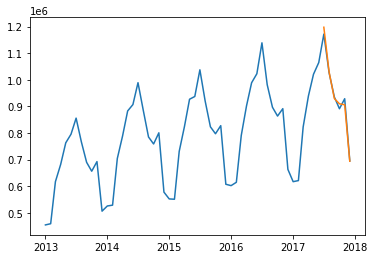

In [83]:
plt.plot(df_sales_pred["date"],df_sales_pred["sales"])
plt.plot( df_sales_pred["date"],df_sales_pred["pred_value"])

In [92]:
df_sales_pred[-6:].pred_value

54    1197220.0
55    1029308.0
56     929412.0
57     909764.0
58     906022.0
59     694134.0
Name: pred_value, dtype: float64

In [158]:
ytest_inverted = scaler.inverse_transform(y_test)
ytest_inverted

ValueError: non-broadcastable output operand with shape (6,1) doesn't match the broadcast shape (6,13)

In [141]:
ytrain_pred = model.predict(X_train,batch_size=1)
ytrain_pred.shape

(41, 1)

In [142]:
#reshape y_pred

ytrain_pred =ytrain_pred.reshape(ytrain_pred.shape[0], 1,ytrain_pred.shape[1])

#rebuild test set for inverse transform

pred_train_set = []
for index in range(0,len(ytrain_pred)):
    print(np.concatenate([ytrain_pred[index],X_train[index]],axis=1))
    pred_train_set.append(np.concatenate([ytrain_pred[index],X_train[index]],axis=1))
    
#reshape pred_test_set

pred_train_set = np.array(pred_train_set)

pred_train_set = pred_train_set.reshape(pred_train_set.shape[0], pred_train_set.shape[2])

#inverse transform

pred_train_set_inverted = scaler.inverse_transform(pred_train_set)
pred_train_set_inverted

[[ 0.13459988  0.15255919 -0.80434393  0.23024212 -0.0447346  -0.25830878
  -0.3186859   0.40696724  0.26794062  0.50957454  0.42966779  0.8922929
   0.12955024]]
[[ 0.88453919  0.07686073  0.15255919 -0.80434393  0.29561828 -0.0447346
  -0.25830878 -0.33606217  0.40696724  0.26794062  0.50957454  0.42966779
   0.8922929 ]]
[[ 0.412       0.8783514   0.07686073  0.15255919 -0.79394659  0.29561828
  -0.0447346  -0.27488947 -0.33606217  0.40696724  0.26794062  0.50957454
   0.42966779]]
[[ 0.42803794  0.45643845  0.8783514   0.07686073  0.21380721 -0.79394659
   0.29561828 -0.05850103 -0.27488947 -0.33606217  0.40696724  0.26794062
   0.50957454]]
[[ 0.14746474  0.49999418  0.45643845  0.8783514   0.13408606  0.21380721
  -0.79394659  0.28633667 -0.05850103 -0.27488947 -0.33606217  0.40696724
   0.26794062]]
[[ 0.42387885  0.1739178   0.49999418  0.45643845  0.97816867  0.13408606
   0.21380721 -0.81758535  0.28633667 -0.05850103 -0.27488947 -0.33606217
   0.40696724]]
[[-0.51045507  0.4

array([[  15524.71960767,   19380.        , -186036.        ,
          36056.        ,  -33320.        ,  -76854.        ,
         -89161.        ,   60325.        ,   32355.        ,
          80968.        ,   64892.        ,  157965.        ,
           4513.        ],
       [ 176512.31591555,    3130.        ,   19380.        ,
        -186036.        ,   36056.        ,  -33320.        ,
         -76854.        ,  -89161.        ,   60325.        ,
          32355.        ,   80968.        ,   64892.        ,
         157965.        ],
       [  75073.51010236,  175184.        ,    3130.        ,
          19380.        , -186036.        ,   36056.        ,
         -33320.        ,  -76854.        ,  -89161.        ,
          60325.        ,   32355.        ,   80968.        ,
          64892.        ],
       [  78516.33479747,   84613.        ,  175184.        ,
           3130.        ,   19380.        , -186036.        ,
          36056.        ,  -33320.        ,  -76854

In [153]:
pred_train_set_inverted

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,15524.719608,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0,4513.0
1,176512.315916,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0
2,75073.510102,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0
3,78516.334797,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0
4,18286.386494,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0
5,77623.512722,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0
6,-122947.614153,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0
7,-84351.260519,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0
8,-30479.878556,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0
9,33055.421429,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0


In [144]:
#create dataframe that shows the predicted sales

result_list = []
sales_dates = list(df_supervised.iloc[0:41].date)
act_sales = list(df_supervised.iloc[0:41].sales)
for index in range(0,len(pred_train_set_inverted)):
    result_dict = {}
    result_dict['pred_value'] = int(pred_train_set_inverted[index][0] + act_sales[index])
    result_dict['date'] = sales_dates[index]
    result_list.append(result_dict)
df_result1 = pd.DataFrame(result_list)

In [145]:
#list(df_sales.iloc[0:41].date)

In [146]:
#list(df_sales.iloc[0:41].sales)

In [147]:
#df_result1

In [148]:
#df_sales.iloc[0:41].sales

In [149]:
pred_train_set_inverted= pd.DataFrame(pred_train_set_inverted)
pred_train_set_inverted.shape

(41, 13)

In [150]:
import math
# calculate root mean squared error
#trainScore = math.sqrt(mean_squared_error(t, trainPredict[:,0]))
#print('Train Score: %.2f RMSE' % (trainScore))

from sklearn.metrics import mean_squared_error
trainScore = math.sqrt(mean_squared_error(df_supervised.iloc[0:41].sales,pred_train_set_inverted[0]))
print('Train Score: %.2f RMSE' % (trainScore))

Train Score: 821581.93 RMSE


In [151]:


testScore = math.sqrt(mean_squared_error(df_sales_pred[-6:].sales,df_sales_pred[-6:].pred_value))
print('Test Score: %.2f RMSE' % (testScore))



Test Score: 16214.26 RMSE


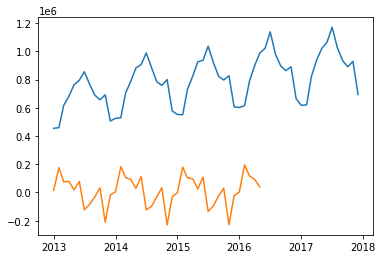

In [152]:
plt.plot(df_sales["date"],df_sales["sales"])
plt.plot( df_sales.iloc[0:41].date,pred_train_set_inverted[0])